# EPA1361 - Model-Based Decision Making

## Multi-model analysis

This exercise uses a simple version of the [Lotka-Volterra predator-prey equations](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations) to show how the EMA Workbench can be used for a
multi-model analysis, in addition to typical parametric/structural uncertainties. This will let you test the connectors provided in the Workbench for Excel, NetLogo, and Vensim / PySD; we'll also use the models for the sensitivity analysis exercise in week 3.

* Using the three model files provided and the Python function below, define model objects for each implementation (Excel, NetLogo, Vensim/PySD, and Python), and test them using a single ensemble. Use 50 experiments sampled from the parameters below (so that each experiment will be executed for the 4 models, for a total of 200), and retrieve outputs for the _TIME_, _predators_, and _prey_ variables.
    * excel and vensim are only supported on windows
    * vensim requires 32 bit python, and a 7.1!! version of vensim DSS
    * Netlogo supoprt depends on [jpype](http://jpype.readthedocs.io/en/latest/install.html) and [pynetlogo](https://pynetlogo.readthedocs.io/en/latest/). Also, if you don't have NetLogo installed, please get it from [NetLogo 6.0](https://ccl.northwestern.edu/netlogo/download.shtml) 
    * for pysd, see [its documentation](http://pysd.readthedocs.io/en/master/installation.html)
    * If possible try to work with all model versions, but even 2 or 3 (pure python and something else should be sufficient).
    

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |
|Final time	    |365	    |
|dt	    |0.25	    |

* Note that your EMA Workbench installation includes example scripts for the different connectors. The different model objects follow a similar syntax but will need to be slightly adjusted depending on the software (e.g. to specify the NetLogo run length or the sheet name in Excel). 

* These model objects can be used with a replication functionality (for instance to test the effect of stochastic uncertainty in a NetLogo model), which repeats a given experiment over multiple replications. You can use a single replication in this exercise as the models are not stochastic. By default, each outcome array will then have a shape of (# experiments, # replications, # time steps). Try adapting the outcome arrays so that they can be used with the _lines_ plotting function of the Workbench, and plot the results grouped by model.

* To check the graphical results, find the maximum absolute error of the time series you obtained for the _prey_ variable in the Excel, NetLogo, and Vensim/PySD models, relative to the Python function. 

# Imports

In [2]:
import sys
!{sys.executable} -m pip install pysd
!{sys.executable} -m pip install JPype1
!{sys.executable} -m pip install pynetlogo

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, perform_experiments, ema_logging)

from ema_workbench.connectors.netlogo import NetLogoModel
from ema_workbench.connectors.excel import ExcelModel
from ema_workbench.connectors.pysd_connector import PysdModel

from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS, MultiprocessingEvaluator, SequentialEvaluator
from ema_workbench.analysis.plotting import lines, Density

# Python Model

In [4]:
#Define the function
def PredPrey(prey_birth_rate=0.025, predation_rate=0.0015, predator_efficiency=0.002,
             predator_loss_rate=0.06, initial_prey=50, initial_predators=20, dt=0.25, final_time=365, reps=1):

    #Initial values
    predators, prey, sim_time = [np.zeros((reps, int(final_time/dt)+1)) for _ in range(3)]
    
    for r in range(reps):
        predators[r,0] = initial_predators
        prey[r,0] = initial_prey

        #Calculate the time series
        for t in range(0, sim_time.shape[1]-1):

            dx = (prey_birth_rate*prey[r,t]) - (predation_rate*prey[r,t]*predators[r,t])
            dy = (predator_efficiency*predators[r,t]*prey[r,t]) - (predator_loss_rate*predators[r,t])

            prey[r,t+1] = max(prey[r,t] + dx*dt, 0)
            predators[r,t+1] = max(predators[r,t] + dy*dt, 0)
            sim_time[r,t+1] = (t+1)*dt
    
    #Return outcomes
    return {'TIME':sim_time,
            'predators':predators,
            'prey':prey}

#Load the model
python_model = Model("pythonmodel", function=PredPrey)

#Define uncertainties
python_model.uncertainties = [RealParameter("prey_birth_rate", 0.015, 0.035),
                                RealParameter("predation_rate", 0.0005, 0.003),
                                RealParameter("predator_efficiency", 0.001, 0.004),
                                RealParameter("predator_loss_rate", 0.04, 0.08)]   

#Define Outcomes
python_model.outcomes = [
                        TimeSeriesOutcome("TIME"),
                        TimeSeriesOutcome("predators"), 
                        TimeSeriesOutcome("prey")]  

# NetLogo Model

In [5]:
netlogo_model = NetLogoModel(name="netlogomodel", wd = "model/", model_file="PredPrey.nlogo")

#NetLogo Settings
netlogo_model.run_length = 100
netlogo_model.replications = 10

#Define uncertainties
netlogo_model.uncertainties = [RealParameter("prey_birth_rate", 0.015, 0.035),
                                RealParameter("predation_rate", 0.0005, 0.003),
                                RealParameter("predator_efficiency", 0.001, 0.004),
                                RealParameter("predator_loss_rate", 0.04, 0.08)]   

#Define Outcomes
netlogo_model.outcomes = [TimeSeriesOutcome("TIME"),
                        TimeSeriesOutcome("predators"), 
                        TimeSeriesOutcome("prey")] 

# PySD Model

In [6]:
#CONNECTION OF THE MODEL TO THE WORKBENCH
#Instantiate the model
pysd_model = PysdModel(name='pysdmodel', mdl_file="model/PredPrey.mdl")
#Define uncertainties
pysd_model.uncertainties = [RealParameter("prey_birth_rate",0.015, 0.035),
                                RealParameter("predation_rate", 0.0005, 0.003),
                                RealParameter("predator_efficiency", 0.001, 0.004),
                                RealParameter("predator_loss_rate", 0.04, 0.08)]   
#Define Outcomes
pysd_model.outcomes = [TimeSeriesOutcome("TIME"),
                        TimeSeriesOutcome("predators"), 
                        TimeSeriesOutcome("prey")]  

# Excel Model
Does not work on OS X

In [7]:
excel_model = ExcelModel("excelmodel", wd="model/", model_file='PredPrey.xlsx')

#Define uncertainties
excel_model.uncertainties = [RealParameter("prey_birth_rate", 0.015, 0.035),
                            RealParameter("predation_rate", 0.0005, 0.003),
                            RealParameter("predator_efficiency", 0.001, 0.004),
                            RealParameter("predator_loss_rate", 0.04, 0.08)]                       

#Define Outcomes
excel_model.outcomes = [TimeSeriesOutcome("TIME"), #Time outcome
                        TimeSeriesOutcome("predators"),  #Predators outcome
                        TimeSeriesOutcome("prey")]  #Prey outcome

#Define Name of the Sheet
excel_model.default_sheet = "Sheet1"


# Model Experiments

In [8]:
ema_logging.log_to_stderr(ema_logging.INFO)
#experiments, outcomes = perform_experiments(models= [python_model, netlogo_model, excel_model], scenarios=50)
experiments, outcomes = perform_experiments(models = [python_model, excel_model, pysd_model], scenarios = 50)

[MainProcess/INFO] performing 50 scenarios * 1 policies * 3 model(s) = 150 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 15 cases completed
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 45 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 75 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] 105 cases completed
[MainProcess/INFO] 120 cases completed
[MainProcess/INFO] 135 cases completed
[MainProcess/INFO] 150 cases completed
[MainProcess/INFO] experiments finished


In [21]:
with SequentialEvaluator(p_model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=50)

[MainProcess/INFO] performing 50 scenarios * 1 policies * 1 model(s) = 50 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 5 cases completed
[MainProcess/INFO] 10 cases completed
[MainProcess/INFO] 15 cases completed
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 25 cases completed
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 35 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 45 cases completed
[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] experiments finished


# Display results

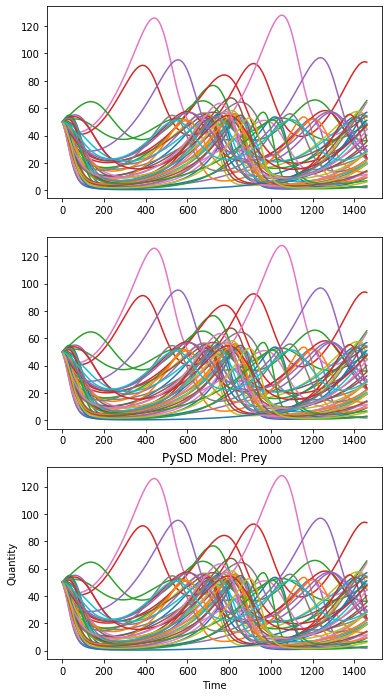

In [21]:
import seaborn
import pandas as pd

fig, axs = plt.subplots(3)

for i in range(50):
    axs[0].plot(outcomes['prey'][i].T)
plt.ylabel('Quantity')
plt.xlabel('Time')
plt.title('Python Model: Prey')

for i in range(50,100):
    axs[1].plot(outcomes['prey'][i].T)
    plt.ylabel('Quantity')
    plt.xlabel('Time')
    plt.title('Excel Model: Prey')

for i in range(100,150):
    axs[2].plot(outcomes['prey'][i].T)
    plt.ylabel('Quantity')
    plt.xlabel('Time')
    plt.title('PySD Model: Prey')

fig.set_size_inches(6,12)
plt.show()

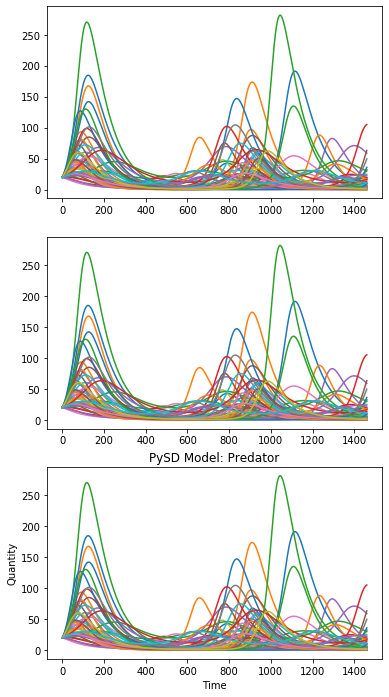

In [26]:
fig, axs = plt.subplots(3)

for i in range(50):
    axs[0].plot(outcomes['predators'][i].T)
# axs[0].ylabel('Quantity')
# axs[0].xlabel('Time')
# ax[0].title('Python Model: Predator')

for i in range(50,100):
    axs[1].plot(outcomes['predators'][i].T)
    # axs[1].ylabel('Quantity')
    # axs[1].xlabel('Time')
    # ax[1].title('Excel Model: Predator')

for i in range(100,150):
    axs[2].plot(outcomes['predators'][i].T)
    plt.ylabel('Quantity')
    plt.xlabel('Time')
    plt.title('PySD Model: Predator')

fig.set_size_inches(6,12)
plt.show()

In [25]:
experiments

,predation_rate,predator_efficiency,predator_loss_rate,prey_birth_rate,scenario,policy,model
0,0.002015,0.002437,0.047532,0.025571,400,None,pythonmodel
1,0.001446,0.003568,0.064484,0.015979,401,None,pythonmodel
2,0.002627,0.001377,0.051027,0.022837,402,None,pythonmodel
3,0.002681,0.002339,0.077518,0.016680,403,None,pythonmodel
4,0.000594,0.003672,0.052491,0.015227,404,None,pythonmodel
5,0.001834,0.003816,0.063847,0.021941,405,None,pythonmodel
6,0.002174,0.001176,0.045445,0.026735,406,None,pythonmodel
7,0.002148,0.003209,0.060530,0.028432,407,None,pythonmodel
8,0.002096,0.003708,0.057661,0.016399,408,None,pythonmodel
9,0.002372,0.001071,0.070041,0.018162,409,None,pythonmodel


In [26]:
list(outcomes.keys())[1:]

['predators', 'prey']

ValueError: x and y can be no greater than 2-D, but have shapes (1461, 1) and (1461, 1, 50)

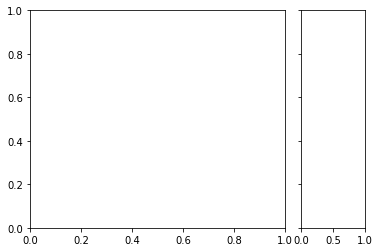

In [27]:
#VISUALIZATION OF THE MODEL OUTCOMES 2:
from ema_workbench.analysis import plotting, plotting_util

for outcome in list(outcomes.keys())[1:]:
    plotting.lines(experiments, outcomes, outcomes_to_show=outcome, 
                   density=plotting_util.Density.HIST)
plt.show()